In [1]:
!pip install pandas numpy nltk matplotlib tqdm wordcloud bs4
#use in jupyter: pip install pandas numpy nltk matplotlib tqdm wordcloud bs4

In [2]:
!pip install spacy && python -m spacy download en_core_web_sm
#use in jupyter: pip install spacy && python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
#All imports
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import os
import time
import re
import spacy
import unicodedata
import collections
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Web Scraping Basics: Inspection, Parsing, and Permissions

Web scraping is a method to automatically extract data from websites. Below are the basic steps and best practices to get started:

## 1. Inspecting a Web Page

Before you start scraping, you need to understand the structure of the webpage:

- **Open the Web Page in Your Browser:**  
  Navigate to the page you want to scrape.

- **Open Developer Tools:**  
  Right-click anywhere on the page and select "Inspect" (or "Inspect Element"). Alternatively, press `F12` or `Ctrl+Shift+I` (Windows) / `Cmd+Option+I` (Mac). This opens the developer tools panel.

- **Use the Inspector Tool:**  
  Click on the arrow icon (usually found in the top-left corner of the developer tools panel). This tool allows you to hover over the page. When you click on a specific element (like an article title or paragraph), the corresponding HTML is highlighted in the panel.  
  *Example:*  
  If article titles are wrapped in `<h3 class="post__title">` tags, you know to target these tags in your code.

## 2. Checking Scraping Permissions

Before scraping, it's important to verify that the website allows it:

- **Robots.txt:**  
  Websites use a file named `robots.txt` to tell web crawlers (including scrapers) which parts of the site are allowed to be accessed.  
  To check a website's permissions, append `/robots.txt` to its URL (e.g., [https://www.theguardian.com/robots.txt](https://www.theguardian.com/robots.txt)).

- **Our Example URLs:**  
  For this project, the following websites have been verified to allow scraping:
  - [Climate Change News](https://www.climatechangenews.com/?s=climate+change)
  - [NASA Climate Change Stories](https://science.nasa.gov/climate-change/stories/)
  - [Inside Climate News](https://insideclimatenews.org/?s=climate+change)

- **Note:**  
  Some websites such as The Guardian, BBC, CNN, etc., have restrictions in their `robots.txt` file. If you're scraping for official or commercial purposes, make sure to review and adhere to these guidelines.

## 3. Parsing the Web Page

After inspecting the page and confirming permissions, you need to extract the data:

- **Identify Target Elements:**  
  Look at the HTML structure to determine where the data you need is located.  
  *For example:*  
  - Article titles might be inside `<h3 class="post__title">` tags.
  - Article links are typically found inside `<a>` tags.
  - Article snippets or paragraphs are within `<p>` tags.

- **Write Your Scraper:**  
  Use a parsing library like BeautifulSoup in Python.  
  In your code, use the identified tags and classes to extract the required elements.  
  *Example:*  
  If titles are in `<h3 class="post__title">`, instruct your scraper to find all `<h3>` elements with that class, and then extract the `<a>` tag within to get both the title and the URL.

---

This provides a basic overview of how to inspect and parse a webpage, as well as ensuring you're allowed to scrape the data. Always inspect the page first to understand its structure and check the `robots.txt` file for scraping permissions before writing your code. Now, let's see it step by step


In [4]:
def check_and_parse_url(url, timeout=10, print_html=True):
    """
    Checks if a URL is accessible, then parses and optionally prints its HTML.

    Parameters:
    -----------
    url : str
        The URL to check and parse
    timeout : int
        Timeout in seconds for the request
    print_html : bool
        Whether to print the HTML content

    Returns:
    --------
    tuple
        (success_bool, soup_object, status_code)
    """
    # Print the URL being checked for clarity.
    print(f"Checking URL: {url}")

    # Define headers with a realistic User-Agent to avoid being blocked by the website.
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        # Record the start time to measure how long the request takes.
        start_time = time.time()
        # Send an HTTP GET request to the specified URL with the headers and timeout.
        response = requests.get(url, headers=headers, timeout=timeout)
        # Calculate the total request time (this value is not used further but can be useful for logging).
        request_time = time.time() - start_time

        # Check if the HTTP response status code indicates success (200 OK).
        if response.status_code == 200:
            print(f"Success! Status code: 200")

            # Parse the HTML content of the response using BeautifulSoup.
            soup = BeautifulSoup(response.text, 'html.parser')

            # Optionally print the prettified HTML content.
            if print_html:
                print("\n----- HTML Content -----")
                print(soup.prettify()) #prettify() is used to make it easily understandable
                print("----- End of preview -----\n")

            # Return a tuple indicating success, the parsed BeautifulSoup object, and the status code.
            return True, soup, response.status_code

        else:
            # If the status code is not 200, print a message indicating the code and return a failure.
            print(f"URL accessible but returned status code: {response.status_code}")
            return False, None, response.status_code

    except requests.exceptions.Timeout:
        # Handle the situation where the request takes longer than the specified timeout.
        print(f"Request timed out after {timeout} seconds")
        return False, None, None

    except requests.exceptions.ConnectionError:
        # Handle errors where the connection to the URL fails.
        print("Connection error - site may be down or URL might be invalid")
        return False, None, None

    except requests.exceptions.RequestException as e:
        # Catch-all for any other request-related errors.
        print(f"Error: {str(e)}")
        return False, None, None


In [5]:
# Example usage
url = "https://www.climatechangenews.com/?s=climate+change"
check_and_parse_url(url, timeout=10, print_html=True)

Checking URL: https://www.climatechangenews.com/?s=climate+change
Success! Status code: 200

----- HTML Content -----
<!DOCTYPE html>
<html lang="en-GB">
 <head>
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=G-1LNFHN9MZ6" type="8176fd47ab407b98c0b0140f-text/javascript">
  </script>
  <script type="8176fd47ab407b98c0b0140f-text/javascript">
   window.dataLayer = window.dataLayer || [];
            function gtag(){dataLayer.push(arguments);}
            gtag('js', new Date());

            gtag('config', 'G-1LNFHN9MZ6');
  </script>
  <script type="8176fd47ab407b98c0b0140f-text/javascript">
   (function(c,l,a,r,i,t,y){
                c[a]=c[a]||function(){(c[a].q=c[a].q||[]).push(arguments)};
                t=l.createElement(r);t.async=1;t.src="https://www.clarity.ms/tag/"+i;
                y=l.getElementsByTagName(r)[0];y.parentNode.insertBefore(t,y);
            })(window, document, "clarity", "script", "pvb2bgqpyh");
  </script>
  <meta charset="utf-8"/>
  <me

(True,
 <!DOCTYPE html>
 <html lang="en-GB"><head>
 <script async="" src="https://www.googletagmanager.com/gtag/js?id=G-1LNFHN9MZ6" type="8176fd47ab407b98c0b0140f-text/javascript"></script> <script type="8176fd47ab407b98c0b0140f-text/javascript">window.dataLayer = window.dataLayer || [];
             function gtag(){dataLayer.push(arguments);}
             gtag('js', new Date());
 
             gtag('config', 'G-1LNFHN9MZ6');</script> <script type="8176fd47ab407b98c0b0140f-text/javascript">(function(c,l,a,r,i,t,y){
                 c[a]=c[a]||function(){(c[a].q=c[a].q||[]).push(arguments)};
                 t=l.createElement(r);t.async=1;t.src="https://www.clarity.ms/tag/"+i;
                 y=l.getElementsByTagName(r)[0];y.parentNode.insertBefore(t,y);
             })(window, document, "clarity", "script", "pvb2bgqpyh");</script> <meta charset="utf-8"/><meta content="" name="description"/><meta content="width=device-width, initial-scale=1" name="viewport"/><title>You searched for cli

## Getting individual article links from main pages

In this section, we define functions to help us scrape article links and titles from different web pages. We work with three different websites, each with its own HTML structure. Here's what each function does:

1. **get_articles_from_page(url):**  
   - Checks which website the URL belongs to.  
   - Uses the appropriate HTML patterns to extract article links and titles.  
   - Returns a list of articles, where each article is a dictionary containing a URL and a title.

2. **select_articles(articles):**  
   - Displays the list of extracted article titles with numbers.
   - Prompts the user to enter the numbers of the articles they want.
   - Returns a list of URLs for the selected articles.

3. **process_page(url):**  
   - Combines the two functions above.
   - It first extracts the articles from the given page.
   - Then, it lets the user choose which articles to keep.
   - Returns the selected article URLs.
   

# Understanding BeautifulSoup Parsing and Common Methods

The below code explains how BeautifulSoup is used to parse HTML and extract information. We will focus on these key concepts:

- Creating a BeautifulSoup object with `html.parser`
- Using the `find` method
- Using the `find_all` method
- Extracting text with `get_text`
- Cleaning up text with `strip`

This is everything required to understand the basics

Here, we use three websites and scrape five articles from each of them, so totally 15 articles

In [6]:
def get_articles_from_page(url):
    """
    Given a URL, this function checks which website it belongs to
    and extracts article links and titles using the appropriate HTML structure.

    Returns:
        articles (list): A list of dictionaries with keys 'url' and 'title'.
    """
    try:
        # Make a GET request to the URL
        response = requests.get(url)
        # Check if the page is successfully retrieved
        if response.status_code != 200:
            print("Error retrieving page:", url)
            return []
    except Exception as e:
        # Print error if the request fails
        print("Error fetching URL:", e)
        return []

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = []

    # Check which website we are dealing with and extract data accordingly:
    if "climatechangenews.com" in url:
        # Look for <h3> tags with class "post__title" that contain the article link and title
        h3_tags = soup.find_all("h3", class_="post__title")
        for tag in h3_tags:
            a_tag = tag.find("a")  # Find the <a> tag within the <h3> tag
            if a_tag:
                # Add the URL and title to the articles list
                articles.append({"url": a_tag["href"], "title": a_tag.get_text(strip=True)})

    elif "science.nasa.gov" in url:
        # Look for <a> tags with class "hds-content-item-heading"
        a_tags = soup.find_all("a", class_="hds-content-item-heading")
        for a_tag in a_tags:
            # Inside these <a> tags, find the <div> with the title text
            div = a_tag.find("div", class_="hds-a11y-heading-22")
            if div:
                articles.append({"url": a_tag["href"], "title": div.get_text(strip=True)})

    elif "insideclimatenews.org" in url:
        # For Inside Climate News, look for <a> tags that contain an <h2> tag with class "entry-title"
        a_tags = soup.find_all("a")
        for a_tag in a_tags:
            h2 = a_tag.find("h2", class_="entry-title")
            if h2:
                articles.append({"url": a_tag["href"], "title": h2.get_text(strip=True)})
    else:
        # If the website is not recognized, print a message
        print("Website not recognized for URL:", url)

    return articles

def select_articles(articles):
    """
    Prints the titles of the articles with index numbers, then prompts the user
    to enter the number(s) corresponding to the articles to select.

    Returns:
        selected_urls (list): A list of article URLs that the user selected.
    """
    if not articles:
        print("No articles found.")
        return []

    # Print each article title with a corresponding number
    print("Found the following articles:")
    for idx, article in enumerate(articles):
        print(f"{idx+1}: {article['title']}")

    # Ask the user to enter the numbers of the articles they want, separated by commas
    user_input = input("Enter the numbers of the articles you want (comma separated): ")
    try:
        # Convert the input into a list of indices (adjusting for 0-based indexing)
        indices = [int(x.strip()) - 1 for x in user_input.split(",")]
    except ValueError:
        print("Invalid input. Please enter valid numbers separated by commas.")
        return []

    # Create a list for the selected article URLs based on the indices provided
    selected_urls = []
    for idx in indices:
        if 0 <= idx < len(articles):
            selected_urls.append(articles[idx]["url"])
        else:
            print(f"Index {idx+1} is out of range.")

    return selected_urls

def process_page(url):
    """
    Given a URL of one of the target pages, this function:
      - Extracts article links and titles based on the site's structure.
      - Prints the titles for you to review.
      - Prompts you to enter the numbers corresponding to the articles you want.

    Returns:
        selected_urls (list): A list of the selected article URLs.
    """
    # Extract all articles from the given page using the get_articles_from_page function
    articles = get_articles_from_page(url)
    # Allow the user to choose which articles they want using the select_articles function
    selected_urls = select_articles(articles)
    return selected_urls


In [7]:
# Page 1: climatechangenews.com
url1 = "https://www.climatechangenews.com/?s=climate+change"
print("Processing page:", url1)
selected_from_page1 = process_page(url1)
print("Selected article URLs from page 1:", selected_from_page1)

# Page 2: science.nasa.gov
url2 = "https://science.nasa.gov/climate-change/stories/"
print("\nProcessing page:", url2)
selected_from_page2 = process_page(url2)
print("Selected article URLs from page 2:", selected_from_page2)

# Page 3: insideclimatenews.org
url3 = "https://insideclimatenews.org/?s=climate+change"
print("\nProcessing page:", url3)
selected_from_page3 = process_page(url3)
print("Selected article URLs from page 3:", selected_from_page3)

Processing page: https://www.climatechangenews.com/?s=climate+change
Found the following articles:
1: Climate change helped turn LA into dry tinderbox before fires, scientists find
2: Nine of our best climate change stories from 2024
3: New European Parliament must act on climate change as a systemic threat
4: Global billionaires tax to fight climate change, hunger rises up political agenda
5: Six takeaways from 2023’s climate change news
6: Morocco’s centuries-old irrigation system under threat from climate change
7: IPCC highlights rich nations’ failure to help developing world adapt to climate change
8: COP28 boss urges Big Oil to join fight against climate change
9: UAE’s Cop28 boss calls for “course correction” on climate change
10: Despite killer floods, Nigerian presidential frontrunners dismiss climate change
11: Climate Home’s five must-read climate change stories from 2022
12: Which countries are ‘particularly vulnerable’ to climate change?
13: Grenada’s Simon Stiell appointe

# Extracting Headers and Paragraphs from a Webpage

This section explains two key functions for extracting content from a webpage using BeautifulSoup:

1. **extract_headers(url):**  
   Extracts all `<h1>` headers from a given webpage.  
2. **extract_paragraphs(url):**  
   Extracts all `<p>` paragraphs from a given webpage.

Both functions:
- Use the `requests` library to fetch the webpage with a timeout.
- Handle potential errors with exception handling.
- Set the proper encoding based on the response.
- Like previous codes, creates a BeautifulSoup object using the `'html.parser'` to parse the HTML.
- Use `find_all` to retrieve all matching tags.
- Use `get_text().strip()` to extract and clean text from the tags, preserving any hyperlinked text inside them.

In [8]:
def extract_headers(url):
    """
    Extract all h1 headers from a webpage URL, preserving hyperlinked text.

    Parameters:
    -----------
    url : str
        The URL of the webpage to extract headers from

    Returns:
    --------
    list
        List of all h1 header texts found on the page
    """
    try:
        # Send an HTTP GET request to the URL with a 10-second timeout.
        response = requests.get(url, timeout=10)
        # Raise an exception if the server returns an error status code.
        response.raise_for_status()

        # Set the encoding of the response to the apparent encoding detected.
        response.encoding = response.apparent_encoding

        # Parse the HTML content using BeautifulSoup with the built-in 'html.parser'.
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find all <h1> tags in the HTML document.
        headers = soup.find_all("h1")

        # Initialize an empty list to store the header texts.
        titles = []
        # Loop through each <h1> tag found.
        for header in headers:
            # Extract the text content from the header and remove extra whitespace.
            header_text = header.get_text().strip()
            # Append the cleaned header text to the titles list.
            titles.append(header_text)

        # Return the list of header texts.
        return titles

    except Exception as e:
        # Print an error message if an exception occurs and return an empty list.
        print(f"Error extracting headers from {url}: {str(e)}")
        return []


In [9]:
#Example usage
url = "https://www.nasa.gov/missions/nisar/how-us-indian-nisar-satellite-will-offer-unique-window-on-earth/"
titles = extract_headers(url)
#Print Headers
if titles:
    print("Found headers:")
    for i, title in enumerate(titles, 1):
        print(f"{i}. {title}")
else:
    print("No h1 headers found")


Found headers:
1. How US-Indian NISAR Satellite Will Offer Unique Window on Earth


In [10]:
def extract_paragraphs(url):
    """
    Extract all paragraphs from a webpage URL, preserving hyperlinked text.

    Parameters:
    -----------
    url : str
        The URL of the webpage to extract paragraphs from

    Returns:
    --------
    list
        List of all paragraph texts found on the page
    """
    try:
        # Send an HTTP GET request to the URL with a 10-second timeout.
        response = requests.get(url, timeout=10)
        # Raise an exception if the response contains an HTTP error.
        response.raise_for_status()

        # Set the response encoding to the apparent encoding detected.
        response.encoding = response.apparent_encoding

        # Parse the HTML content with BeautifulSoup using the 'html.parser'.
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find all <p> tags in the HTML document.
        paragraphs = soup.find_all("p")

        # Initialize an empty list to store the paragraph texts.
        content = []
        # Loop through each paragraph tag found.
        for para in paragraphs:
            # Extract the text content from the paragraph and remove extra whitespace.
            para_text = para.get_text().strip()
            # Append the cleaned text to the content list.
            content.append(para_text)

        # Return the list of paragraph texts.
        return content

    except Exception as e:
        # Print an error message if an exception occurs and return an empty list.
        print(f"Error extracting paragraphs from {url}: {str(e)}")
        return []

In [11]:
#Example Usage
url = "https://science.nasa.gov/earth/water-on-earth/nasa-study-crops-forests-responding-to-changing-rainfall-patterns/"
paragraphs = extract_paragraphs(url)
# Print first few paragraphs
for i, para in enumerate(paragraphs[:5], 1):
    if para:
        print(f"Paragraph {i}: {para}")

Paragraph 1: 4 min read
Paragraph 2: Earth’s rainy days are changing: They’re becoming less frequent, but more intense. Vegetation is responding.
Paragraph 3: A new NASA-led study has found that how rain falls in a given year is nearly as important to the world’s vegetation as how much. Reporting Dec. 11 in Nature, the researchers showed that even in years with similar rainfall totals, plants fared differently when that water came in fewer, bigger bursts.
Paragraph 4: In years with less frequent but more concentrated rainfall, plants in drier environments like the U.S. Southwest were more likely to thrive. In humid ecosystems like the Central American rainforest, vegetation tended to fare worse, possibly because it could not tolerate the longer dry spells.
Paragraph 5: Scientists have previously estimated that almost half of the world’s vegetation is driven primarily by how much rain falls in a year. Less well understood is the role of day-to-day variability, said lead author Andrew Fe

We have to understand that sometimes not every para can be a proper one. Like in the above case, we see that p1 is the time and p2 is like a caption for the article. The real para starts from p3.

# Savig finding to csv file

The `save_to_csv` function is designed to scrape an article from a given URL, extract its title and content, and then save this data to a CSV file. It leverages previously defined functions to fetch and parse the webpage, extract headers and paragraphs, and finally organize the extracted information in a structured format using a pandas DataFrame.

## How It Works

1. **Fetch and Parse the Webpage:**  
   - The function first calls `check_and_parse_url` to send a GET request to the URL and obtain a BeautifulSoup object.
   - If the request fails or no valid soup is returned, the function prints an error message and exits early.

2. **Extract the Article Title:**  
   - It uses `extract_headers` to get a list of all `<h1>` header texts from the webpage.
   - The title is selected based on the provided `header_index` (default is 0). If no headers are found, it defaults to "No title found".

3. **Extract the Article Content:**  
   - The function calls `extract_paragraphs` to extract all `<p>` elements from the page.
   - If specific paragraph indices (`para_indices`) are provided, only those paragraphs are selected; otherwise, all extracted paragraphs are used.
   - The selected paragraphs are concatenated into a single string to form the article content.

4. **Create and Save the DataFrame:**  
   - A pandas DataFrame is created with three columns: `title`, `content`, and `url`.
   - Depending on the `append` flag and whether the CSV file already exists, the function either appends the data to an existing CSV (without writing headers again) or creates a new CSV file with headers.
   - The file is saved with UTF-8 encoding (using `utf-8-sig`).

5. **Return Value:**  
   - The function returns a tuple containing a success flag (`True`/`False`) and the DataFrame with the article's data.


In [13]:
def save_to_csv(url, output_csv='climate_articles.csv', header_index=0, para_indices=None, append=True):
    """
    Use existing functions to scrape an article and save to CSV.

    Parameters:
    -----------
    url : str
        URL of the article to scrape.
    output_csv : str
        File path where the CSV output will be saved.
    header_index : int
        The index of the header to use as the article title (default is 0, meaning the first header).
        This is useful because sometimes the first header may not be the desired title.
    para_indices : list or None
        If provided, only use paragraphs at these 0-based indices from the extracted paragraphs.
        If None, all extracted paragraphs are used. This allows us to skip unwanted paragraphs
        (for example, when the first paragraph is an advertisement or unrelated text).
    append : bool
        Determines whether to append the new article data to an existing CSV (True) or create a new CSV (False).

    Returns:
    --------
    tuple
        A tuple (success_bool, dataframe_with_article) where success_bool is True if the operation
        succeeded, and dataframe_with_article is the pandas DataFrame containing the scraped article data.
    """
    try:
        # Use the function check_and_parse_url to verify the URL and get a BeautifulSoup object.
        # We set print_html to False to avoid printing the HTML content.
        success, soup, status = check_and_parse_url(url, print_html=False)

        # If the URL could not be accessed successfully, return False and exit.
        if not success or soup is None:
            print(f"Failed to access URL: {url}")
            return False, None

        # Extract all header texts (e.g., <h1> tags) from the URL using the extract_headers function.
        headers = extract_headers(url)

        # Check if any headers were found. If none, use a default title.
        if not headers:
            print("No headers found")
            title = "No title found"
        else:
            # Use the header_index parameter to select the desired header.
            # This is important because the first header might not always be the best title for the article.
            # For some websites, you might need to use a different index to get the correct title.
            title = headers[header_index] if header_index < len(headers) else headers[0]

        # Extract all paragraph texts (<p> tags) from the URL using the extract_paragraphs function.
        all_paragraphs = extract_paragraphs(url)

        # If para_indices is provided, filter out only those paragraphs at the specified indices.
        # This is useful when not all paragraphs are relevant (e.g., skip introductory text or ads).
        if para_indices is not None:
            paragraphs = [all_paragraphs[i] for i in para_indices if i < len(all_paragraphs)]
        else:
            # If no specific indices are provided, use all paragraphs.
            paragraphs = all_paragraphs

        # Combine all selected paragraphs into a single string to form the content of the article.
        content = " ".join(paragraphs)

        # Create a pandas DataFrame with the scraped article data.
        article_df = pd.DataFrame({
            'url': [url],
            'headline': [title],
            'text': [content],
        })

        # Save the DataFrame to CSV.
        # If 'append' is True and the CSV file already exists, append the data without rewriting headers.
        # Otherwise, create a new CSV file with headers.
        # Here, encoding with utf-8-sig is very important as that will make sure all quotes and similar characters are not messed up while writing to csv
        if append and os.path.exists(output_csv):
            article_df.to_csv(output_csv, mode='a', header=False, index=False, encoding='utf-8-sig')
            print(f"Appended to existing CSV: {output_csv}")
        else:
            article_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
            print(f"Created new CSV: {output_csv}")

        # Return success along with the DataFrame containing the article data.
        return True, article_df

    except Exception as e:
        # Catch any exceptions that occur during processing, print an error message, and return False.
        print(f"Error saving to CSV for {url}: {str(e)}")
        return False, None


In [ ]:
#Example usage

# Scrape specific paragraphs (e.g., only the first 3 paragraphs)

# success, article_df = save_to_csv(
#     url="https://climatechangenews.com/2025/03/01/renewable-energy-milestone/",
#     para_indices=[0, 1, 2],  # Only first 3 paragraphs
#     output_csv="climate_highlights.csv"
# )

In [14]:
# URLs from https://www.climatechangenews.com/?s=climate+change
# urls = [
#     "https://www.climatechangenews.com/2025/01/28/climate-change-helped-turn-la-into-dry-tinderbox-before-fires-scientists-find//",
#     "https://www.climatechangenews.com/2024/06/26/new-european-parliament-must-act-on-climate-change-as-a-systemic-threat/",
#     "https://www.climatechangenews.com/2024/04/19/global-billionaires-tax-to-fight-climate-change-and-hunger-rises-up-political-agenda/",
#     "https://www.climatechangenews.com/2023/03/07/al-jaber-urges-big-oil-to-join-fight-against-climate-changehouston-we-have-a-problem-energy-industry-grapples-with-climate-fight/",
#     "https://www.climatechangenews.com/2023/03/20/ipcc-highlights-rich-nations-failure-to-help-developing-world-adapt-to-climate-change/"
# ]

urls = selected_from_page1 # already we got from before

# Define the parameters you want to use for all URLs
header_index = 0        # Use first h1 for all
para_indices = [1,2,3]  # Extracting paras 1,2,3 as first para[0] is sub heading
output_csv = "rawData.csv"

# Process all URLs with the same parameters
for url in urls:
    print(f"\nProcessing: {url}")
    success, df = save_to_csv(
        url=url,
        header_index=header_index,
        para_indices=para_indices,
        output_csv=output_csv,
        append=True  # Append each new article to the same CSV
    )


print("Finished processing all URLs!")


Processing: https://www.climatechangenews.com/2025/01/28/climate-change-helped-turn-la-into-dry-tinderbox-before-fires-scientists-find/
Checking URL: https://www.climatechangenews.com/2025/01/28/climate-change-helped-turn-la-into-dry-tinderbox-before-fires-scientists-find/
Success! Status code: 200
Created new CSV: rawData.csv

Processing: https://www.climatechangenews.com/2024/06/26/new-european-parliament-must-act-on-climate-change-as-a-systemic-threat/
Checking URL: https://www.climatechangenews.com/2024/06/26/new-european-parliament-must-act-on-climate-change-as-a-systemic-threat/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://www.climatechangenews.com/2024/04/19/global-billionaires-tax-to-fight-climate-change-and-hunger-rises-up-political-agenda/
Checking URL: https://www.climatechangenews.com/2024/04/19/global-billionaires-tax-to-fight-climate-change-and-hunger-rises-up-political-agenda/
Success! Status code: 200
Appended to existing CSV: ra

In [15]:
# URLs from https://science.nasa.gov/climate-change/stories/
# urls = [
#     "https://www.nasa.gov/missions/nisar/how-us-indian-nisar-satellite-will-offer-unique-window-on-earth/",
#     "https://science.nasa.gov/earth/water-on-earth/nasa-study-crops-forests-responding-to-changing-rainfall-patterns/",
#     "https://science.nasa.gov/earth/climate-change/nasa-data-reveals-role-of-green-spaces-in-cooling-cities/",
#     "https://www.nasa.gov/earth/oceans/nasa-data-helps-international-community-prepare-for-sea-level-rise/",
#     "https://www.nasa.gov/earth/first-greenhouse-gas-plumes-detected-with-nasa-designed-instrument/"
# ]

urls = selected_from_page2

# Define the parameters you want to use for all URLs
header_index = 0        # Use first h1 for all
para_indices = [2,3,4]  # paragraphs start from 3rd position
output_csv = "rawData.csv"

# Process all URLs with the same parameters
for url in urls:
    print(f"\nProcessing: {url}")
    success, df = save_to_csv(
        url=url,
        header_index=header_index,
        para_indices=para_indices,
        output_csv=output_csv,
        append=True  # Append each new article to the same CSV
    )

print("Finished processing all URLs!")


Processing: https://www.nasa.gov/missions/nisar/how-us-indian-nisar-satellite-will-offer-unique-window-on-earth/
Checking URL: https://www.nasa.gov/missions/nisar/how-us-indian-nisar-satellite-will-offer-unique-window-on-earth/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://science.nasa.gov/earth/water-on-earth/nasa-study-crops-forests-responding-to-changing-rainfall-patterns/
Checking URL: https://science.nasa.gov/earth/water-on-earth/nasa-study-crops-forests-responding-to-changing-rainfall-patterns/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://science.nasa.gov/earth/climate-change/nasa-data-reveals-role-of-green-spaces-in-cooling-cities/
Checking URL: https://science.nasa.gov/earth/climate-change/nasa-data-reveals-role-of-green-spaces-in-cooling-cities/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://www.nasa.gov/earth/oceans/nasa-data-helps-international-community-prep

In [16]:
# URLS from https://insideclimatenews.org/?s=climate+change
# urls = [
#     "https://insideclimatenews.org/news/02032025/trump-epa-greenhouse-gas-pollution-endangerment-finding/",
#     "https://insideclimatenews.org/news/02032025/new-york-city-heating-systems/",
#     "https://insideclimatenews.org/news/01032025/north-carolina-pfas-plastic-waste-pyrolysis-plant/",
#     "https://insideclimatenews.org/news/01032025/dominion-liquified-natural-gas-storage-facility-virginia/",
#     "https://insideclimatenews.org/news/28022025/todays-climate-birds-live-long-vulnerable-to-global-warming/"
# ]

urls = selected_from_page3

# Define the parameters you want to use for all URLs
header_index = 0          # Use first h1 for all
para_indices = [0,1,2]    # Use first 3 paragraphs as here it is represented correctly
output_csv = "rawData.csv"

# Process all URLs with the same parameters
for url in urls:
    print(f"\nProcessing: {url}")
    success, df = save_to_csv(
        url=url,
        header_index=header_index,
        para_indices=para_indices,
        output_csv=output_csv,
        append=True  # Append each new article to the same CSV
    )

print("Finished processing all URLs!")


Processing: https://insideclimatenews.org/news/02032025/trump-epa-greenhouse-gas-pollution-endangerment-finding/
Checking URL: https://insideclimatenews.org/news/02032025/trump-epa-greenhouse-gas-pollution-endangerment-finding/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://insideclimatenews.org/news/02032025/new-york-city-heating-systems/
Checking URL: https://insideclimatenews.org/news/02032025/new-york-city-heating-systems/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://insideclimatenews.org/news/01032025/north-carolina-pfas-plastic-waste-pyrolysis-plant/
Checking URL: https://insideclimatenews.org/news/01032025/north-carolina-pfas-plastic-waste-pyrolysis-plant/
Success! Status code: 200
Appended to existing CSV: rawData.csv

Processing: https://insideclimatenews.org/news/01032025/dominion-liquified-natural-gas-storage-facility-virginia/
Checking URL: https://insideclimatenews.org/news/01032025/dominion-liq

Now, rawData.csv is ready

#Cleaning Data

##Text Cleaning Overview

This tool cleans and preprocesses climate-related text data from CSV files. It uses Natural Language Processing (NLP) techniques via spaCy to transform raw text into a standardized, clean format suitable for analysis or machine learning applications.

## Features
- Removes HTML tags and formatting elements
- Normalizes Unicode characters for consistent text representation
- Standardizes common abbreviations (e.g., "u.s." → "usa")
- Removes temperature expressions (e.g., "1.3C")
- Cleans year expressions (e.g., "1870s")
- Converts text to lowercase
- Performs lemmatization (converting words to base forms)
- Removes stop words, punctuation, spaces, and numbers
- Handles special cases specific to climate data


## Example
**Before cleaning:**
```
"Climate change helped turn LA into dry tinderbox before fires, scientists find"
```

**After cleaning:**
```
"climate change help turn la dry tinderbox fire scientist find"
```

## Use Cases
- Preprocessing for text analysis and natural language processing
- Data preparation for machine learning models
- Standardizing text data for visualization
- Creating clean datasets for research purposes

## Error Handling
The tool includes comprehensive error handling to manage issues with:
- Missing or corrupted files
- Non-string data types
- spaCy model loading failures
- Processing errors within the cleaning function

In [20]:
import re
import unicodedata
import spacy

# Load the spaCy English language model for text processing.
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    """
    Clean and preprocess input text by removing unwanted elements and normalizing the content.

    Steps performed:
      1. Remove HTML tags.
      2. Normalize Unicode characters (standardizes punctuation and symbols).
      3. Standardize common abbreviations (e.g., convert "u.s." to "usa").
      4. Remove temperature expressions (e.g., "1.3c", "2.6C").
      5. Remove year expressions (e.g., "1870s", "1870's").
      6. Remove dollar symbols.
      7. Replace abbreviated month names (e.g., "dec." to "december", "aug." to "august").
      8. Process the text with spaCy: tokenization, lemmatization, and filtering out stop words, punctuation, spaces, numbers, and pronoun placeholders.
      9. Optionally merge tokens split by spaces around an apostrophe.

      Note: Here 3,4,5,6,7 are some of the problems observed with the specific dataset that should be cleaned, it may vary with different articles, so the user should work accordingly and it can be easily done with regex
      It is not necessery that these need to be done but it will be really halpful to process the data

    Parameters:
      text (str): The raw text to be cleaned.

    Returns:
      str: The cleaned text.
    """
    try:
        # If the input is not a string, return an empty string.
        if not isinstance(text, str):
            return ""

        # 1. Remove HTML tags using a regular expression.
        text = re.sub(r'<.*?>', '', text)

        # 2. Normalize Unicode characters to standardize punctuation and symbols.
        text = unicodedata.normalize('NFKC', text)
        # Replace curly apostrophes with straight ones.
        text = text.replace("’", "'").replace("‘", "'")

        # 3. Standardize abbreviations:
        # Replace "u.s.-" (e.g., "u.s.-india") with "usa ".
        text = re.sub(r'\bu\.s\.-', 'usa ', text, flags=re.IGNORECASE)
        # Replace "u.s." with "usa" even if followed by punctuation or at the end of the string.
        text = re.sub(r'\bu\.s\.(?=\W|$)', 'usa', text, flags=re.IGNORECASE)

        # 4. Remove temperature expressions like "1.3c" or "2.6C".
        text = re.sub(r'\b\d+\.\d+[cC]\b', '', text)

        # 5. Remove years formatted like "1870s" or "1870's".
        text = re.sub(r"\b\d{4}(?:'s|s)\b", '', text)

        # 6. Remove dollar symbols.
        text = re.sub(r'\$', '', text)

        # 7. Replace abbreviated month names:
        # Convert "dec." to "december" and "aug." to "august".
        text = re.sub(r'\bdec\.(?=\W|$)', 'december', text, flags=re.IGNORECASE)
        text = re.sub(r'\baug\.(?=\W|$)', 'august', text, flags=re.IGNORECASE)

        # 8. Process the text with spaCy to tokenize, lemmatize, and filter tokens.
        doc = nlp(text)
        tokens = [
            # For each token in the processed document:
            # - Get its lemma (base form), convert to lowercase, and remove extra spaces.
            # - Exclude tokens that are stop words, punctuation, spaces, numbers, or pronoun placeholders.
            token.lemma_.lower().strip()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
            and not token.like_num and token.lemma_ != '-PRON-'
        ]

        # Join the filtered tokens into a single string with spaces.
        cleaned_text = " ".join(tokens)

        # Return the final cleaned text.
        return cleaned_text

    except Exception as e:
        # If an error occurs, print the error message.
        # Return the original text if it is a string, otherwise return an empty string.
        print(f"Error in clean_text function: {str(e)}")
        return text if isinstance(text, str) else ""


In [21]:
df = pd.read_csv('rawData.csv')

# Clean the 'text' column and overwrite it with cleaned text
print("Cleaning text data...")
df['text'] = df['text'].apply(clean_text)

# Save to cleanData.csv
df.to_csv('cleanData.csv', mode='w', index=False, encoding='utf-8-sig')
print("Data cleaning complete! Results saved to cleanData.csv")

Cleaning text data...
Data cleaning complete! Results saved to cleanData.csv


# Processing data - Word Frequency Analysis

## Overview

The `simple_word_analysis` function performs text analysis on climate change articles to identify the most common words and their distribution across documents. This tool helps identify key themes and terminology in climate change discourse.

### Parameters

- `input_csv` (str): Path to a CSV file containing cleaned text data

### Returns

- `pd.DataFrame`: DataFrame with columns 'word', 'count', and 'proportion'

## Process Steps

1. **Data Loading**: Reads the CSV file and extracts text from either the 'content' or 'clean_content' column
2. **Tokenization**: Splits each document's text into individual words
3. **Frequency Counting**: Calculates how many times each word appears in the entire corpus
4. **Top Words Extraction**: Identifies the 10 most common words for analysis
5. **Proportion Calculation**: For each top word, determines the percentage of documents that contain it
6. **Visualization**: Creates two visual representations:
   - Bar chart showing counts of top 10 words
   - Word cloud displaying top 30 words (sized by frequency)
7. **Results Export**: Saves findings to 'results.csv'


In [23]:
def simple_word_analysis(input_csv: str) -> pd.DataFrame:
    """
    Performs a simple word frequency analysis on cleaned text data.

    1. Loads the CSV file and reads the 'content' column (which contains the cleaned text).
    2. Tokenizes each document by splitting on whitespace.
    3. Counts the frequencies of all tokens using collections.Counter.
    4. Extracts the 10 most common tokens for analysis results.
    5. Calculates the proportion of documents that contain each token.
    6. Creates a bar chart visualization for top 10 words.
    7. Creates a word cloud visualization showing top 30 words.
    8. Saves results to results.csv.
    9. Returns a DataFrame with columns: 'word', 'count', and 'proportion', sorted by 'count' descending.

    Parameters:
    -----------
    input_csv : str
        The path to the CSV file containing a 'content' column.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the top 10 words with columns: word, count, proportion.
    """
    # 1. Load and read the text column
    df = pd.read_csv(input_csv)

    # Check which column to use
    text_column = 'text'

    documents = df[text_column].dropna().tolist()

    # 2. Tokenize each document (split on whitespace)
    tokens_per_article = [doc.split() for doc in documents]

    # 3. Flatten all tokens into a single list and count frequencies
    all_tokens = [token for tokens in tokens_per_article for token in tokens]
    word_counter = collections.Counter(all_tokens)

    # 4. Extract the 10 most common tokens for analysis results
    top_10 = word_counter.most_common(10)

    # Also get top 30 for word cloud
    top_30 = word_counter.most_common(30)

    # 5. Calculate the proportion of documents that contain each token
    num_docs = len(tokens_per_article)
    proportions = {}
    for word, _ in top_10:
        # Count how many documents contain this word at least once
        doc_count = sum(1 for tokens in tokens_per_article if word in set(tokens))
        # Calculate percentage and round to 2 decimal places
        proportions[word] = round((doc_count / num_docs) * 100, 2) if num_docs > 0 else 0

    # 6. Build the results DataFrame
    results_data = []
    for word, count in top_10:
        results_data.append({
            "word": word,
            "count": count,
            "proportion": proportions[word]
        })

    results_df = pd.DataFrame(results_data).sort_values(by="count", ascending=False)

    # 7. Create visualizations

    # Bar chart for word frequency
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['word'], results_df['count'], color='skyblue')
    plt.title('Top 10 Most Common Words')
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    # plt.savefig('word_frequency_chart.png')

    # Word cloud visualization with top 30 words
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=30)  # Increased to 30 words

    # Convert top 30 to dictionary for WordCloud
    word_freq_dict = dict(top_30)
    wordcloud.generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Top 30 Words')
    plt.tight_layout()
    # plt.savefig('word_cloud.png')

    # 8. Save results to CSV
    results_df.to_csv('results.csv', index=False)

    return results_df


Top 10 words analysis complete!
      word  count  proportion
0  climate     18       60.00
1   change     16       73.33
2     year     16       60.00
3   global     12       46.67
4    world     11       33.33
5     nasa     11       33.33
6    datum      9       33.33
7     city      9       13.33
8      say      8       46.67
9   carbon      8       20.00

Results saved to results.csv
Visualizations saved as word_frequency_chart.png and word_cloud.png


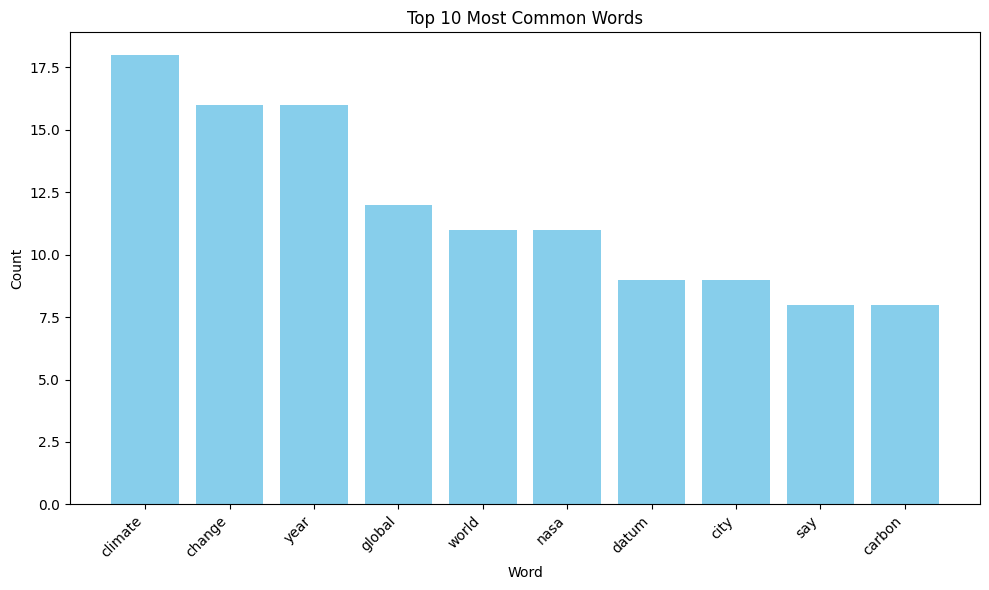

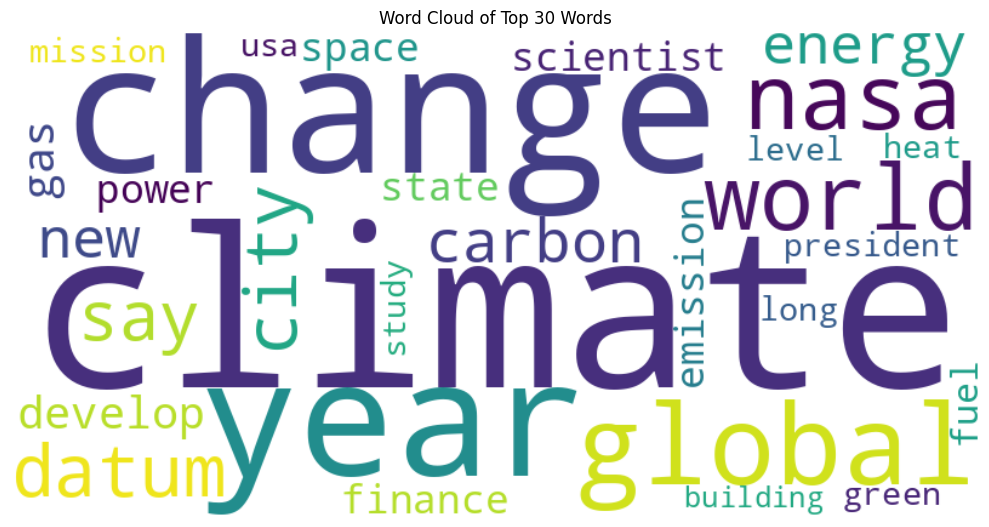

In [24]:
results = simple_word_analysis('cleanData.csv')

# Display the results
print("Top 10 words analysis complete!")
print(results)
print("\nResults saved to results.csv")
print("Visualizations saved as word_frequency_chart.png and word_cloud.png")

The word "data" appears as "datum" in cleaned file because spaCy's lemmatization process [token.lemma_.lower().strip()] converts words to their base dictionary forms. Since "data" is technically the plural form of "datum" in English, the algorithm transforms it to its singular form.

# Optional Advanced Method - TF-IDF Analysis Function

## Overview

The `tfidf_analysis` function performs advanced text analysis to identify the most important terms in climate change documents using TF-IDF (Term Frequency-Inverse Document Frequency) weighting. This approach highlights terms that are distinctively important to specific documents rather than just counting word frequencies.

## What is TF-IDF?

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents:

- **Term Frequency (TF)**: How frequently a term appears in a document
- **Inverse Document Frequency (IDF)**: Downweights terms that appear in many documents

Words with high TF-IDF scores appear frequently in specific documents but are rare across the entire corpus, making them particularly valuable for identifying unique content.

## Technical Process

The function performs the following steps:

1. **Data Loading**
   - Reads the CSV file
   - Extracts text from the 'clean_content' column (falls back to 'content' if needed)
   - Handles any missing values

2. **Document Vectorization**
   - Uses scikit-learn's `CountVectorizer` to convert text documents into a term-document matrix
   - Builds a vocabulary of n-grams (words or phrases) from the documents
   - Creates a sparse matrix where each row corresponds to a document and each column to a term

3. **TF-IDF Transformation**
   - Applies `TfidfTransformer` to convert raw term counts into TF-IDF weights
   - Terms that are common across documents receive lower weights
   - Terms that are frequent in a few documents receive higher weights

4. **Term Importance Calculation**
   - Sums TF-IDF scores for each term across all documents to get overall importance
   - Sorts terms by descending score to identify the most significant terms
   - Selects the top N terms based on the `top_n` parameter

5. **Document Proportion Analysis**
   - For each top term, calculates the percentage of documents containing it
   - Handles single words and multi-word phrases differently for accurate counting

6. **Visualization Creation**
   - Generates a bar chart showing TF-IDF scores for the top terms

7. **Results Export**
   - Creates a DataFrame with the top terms, their TF-IDF scores, and document proportions
   - Returns the DataFrame for further analysis


## Differences from Simple Word Counting

TF-IDF analysis differs from simple word frequency counting in these key ways:

1. **Quality vs. Quantity**: TF-IDF focuses on distinctive terms rather than just frequent ones
2. **Context Awareness**: Downweights common terms that appear across many documents
3. **Multi-word Support**: Can identify important phrases, not just individual words
4. **Document Significance**: Considers how terms are distributed across the document collection


In [25]:
def tfidf_analysis(input_csv: str, top_n: int = 10, ngram_range: tuple = (1, 2)) -> pd.DataFrame:
    """
    Performs a TF-IDF analysis on cleaned text data and returns the top n terms.

    1. Loads the CSV file and reads the 'clean_content' column.
    2. Creates a document-term matrix using CountVectorizer with the given ngram_range.
    3. Transforms the counts into TF-IDF scores.
    4. Extracts the top n terms by summing TF-IDF across documents.
    5. Calculates the proportion of documents that contain each top term.
    6. Creates visualizations of results.
    7. Saves results to CSV and image files.
    8. Returns a DataFrame with columns: 'word', 'tfidf_score', and 'proportion', sorted by 'tfidf_score'.

    Parameters:
    -----------
    input_csv : str
        The path to the CSV file containing a 'clean_content' column.
    top_n : int
        The number of top terms to return.
    ngram_range : tuple
        The n-gram range for tokenizing (default is (1, 2) for unigrams and bigrams).

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the top n terms with columns: word, tfidf_score, proportion.
    """
    # 1. Load and read the text column
    df = pd.read_csv(input_csv)

    # Check which column to use
    text_column = 'text'

    # Get documents and handle NaN values
    documents = df[text_column].dropna().tolist()
    print(f"Analyzing {len(documents)} documents")

    # 2. Create a document-term matrix using CountVectorizer
    # CountVectorizer converts a collection of text documents to a matrix of token counts
    # ngram_range=(1,2) means both single words and pairs of adjacent words are considered
    print(f"Creating document-term matrix with n-grams range {ngram_range}")
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(documents)
    print(f"Matrix shape: {count_matrix.shape} (documents × terms)")

    # 3. Transform the count matrix into TF-IDF scores
    # TF-IDF (Term Frequency-Inverse Document Frequency) weighs terms based on their
    # importance in a document relative to the entire corpus
    print("Calculating TF-IDF scores")
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

    # 4. Extract the top n terms by summing TF-IDF scores across all documents
    # Sum each column (term) across all rows (documents) to get total importance
    print(f"Extracting top {top_n} terms")
    tfidf_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()

    # Get the vocabulary (mapping from feature indices to feature names)
    vocab = vectorizer.get_feature_names_out()

    # Create a dictionary mapping terms to their total TF-IDF scores
    word_tfidf = dict(zip(vocab, tfidf_scores))

    # Sort terms by their scores and select top n
    top_terms = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # 5. Calculate the proportion of documents that contain each top term
    print("Calculating document proportions")
    num_docs = len(documents)
    proportions = {}
    for word, _ in top_terms:
        # Count documents that contain this term
        # For multi-word terms (bigrams), we need to check for the exact phrase
        if " " in word:
            doc_count = sum(1 for doc in documents if word in doc)
        else:
            # For single words, split the document into words and check
            doc_count = sum(1 for doc in documents if word in doc.split())

        # Calculate percentage of documents containing this term
        proportions[word] = round((doc_count / num_docs) * 100, 2) if num_docs > 0 else 0

    # 6. Build the results DataFrame
    data = []
    for word, score in top_terms:
        data.append({
            "word": word,
            "tfidf_score": round(score, 4),  # Round scores for readability
            "proportion": proportions[word]
        })
    results_df = pd.DataFrame(data).sort_values(by="tfidf_score", ascending=False)

    # 7. Create visualizations

    # Bar chart for TF-IDF scores
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    ax = sns.barplot(x="word", y="tfidf_score", hue="word", data=results_df, palette="viridis", legend=False)
    plt.title(f'Top {top_n} Terms by TF-IDF Score', fontsize=14)
    plt.xlabel('Term', fontsize=12)
    plt.ylabel('TF-IDF Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add score labels on top of bars
    for i, p in enumerate(ax.patches):
        score = results_df['tfidf_score'].iloc[i]
        ax.annotate(f'{score:.3f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'bottom',
                   fontsize=9)

    plt.tight_layout()
    # plt.savefig('tfidf_scores.png')

    # Save results to CSV
    # results_df.to_csv('tfidf_results.csv', index=False)
    # print("Results saved to 'tfidf_results.csv'")

    return results_df


Analyzing 15 documents
Creating document-term matrix with n-grams range (1, 2)
Matrix shape: (15, 1925) (documents × terms)
Calculating TF-IDF scores
Extracting top 10 terms
Calculating document proportions

Top terms by TF-IDF score:
      word  tfidf_score  proportion
0  climate       0.6624       60.00
1     year       0.5657       60.00
2    world       0.5030       33.33
3   change       0.5021       73.33
4     city       0.4945       13.33
5     nasa       0.4772       33.33
6   global       0.4660       46.67
7   carbon       0.4247       20.00
8    datum       0.3999       33.33
9  finance       0.3948       26.67


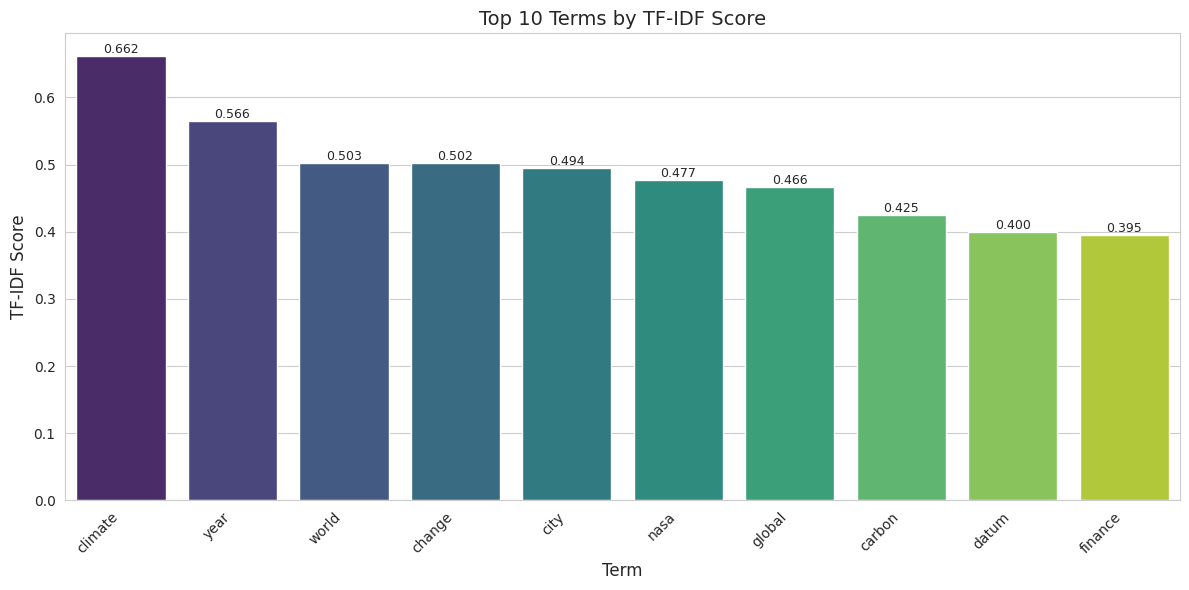

In [26]:
results = tfidf_analysis('cleanData.csv', top_n=10)

# Display the results
print("\nTop terms by TF-IDF score:")
print(results)